In [1]:
import os
import warnings
from get_data import PrepareData
warnings.filterwarnings('ignore')

PATH = 'data'

In [2]:
train = pd.read_csv(os.path.join(PATH, 'train.csv'))
test = pd.read_csv(os.path.join(PATH, 'test.csv'))

x_train, y_train = PrepareData(train).prepare_data()
x_train.shape, y_train.shape

((12879, 13), (12879,))

In [3]:
from sklearn.model_selection import train_test_split

random_state = 42
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, 
                                                    random_state=random_state)

# Modeling

- Random Forest
- Logistic Regression
- XGBoost

## 1. Random Forest

- Precision/Recall/F1: 0.88/0.88/0.88

In [4]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=random_state)
model = rf.fit(X_train, y_train)

In [5]:
pred = model.predict(X_test)

In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [7]:
print(confusion_matrix(y_test, pred))

[[1327  167]
 [ 186 1540]]


In [8]:
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.88      0.89      0.88      1494
          1       0.90      0.89      0.90      1726

avg / total       0.89      0.89      0.89      3220



In [9]:
rf.estimator_params

('criterion',
 'max_depth',
 'min_samples_split',
 'min_samples_leaf',
 'min_weight_fraction_leaf',
 'max_features',
 'max_leaf_nodes',
 'min_impurity_decrease',
 'min_impurity_split',
 'random_state')

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

cv = KFold(5)
cv_scores = cross_val_score(model, X_train, y_train, cv=cv)

print('Cross Val Scores: ', cv_scores)
print('Avg Score of CV: {:.3f}'.format(cv_scores.mean()))

Cross Val Scores:  [ 0.87732919  0.87111801  0.87318841  0.87991718  0.89539099]
Avg Score of CV: 0.879


In [11]:
import operator

importance_dict = {}
for imp, col in zip(rf.feature_importances_, X_train.columns):
    importance_dict[col] = imp

sorted_imp = sorted(importance_dict.items(), key=operator.itemgetter(1))[::-1]

cols = [item[0] for item in sorted_imp]
imps = [item[1] for item in sorted_imp]

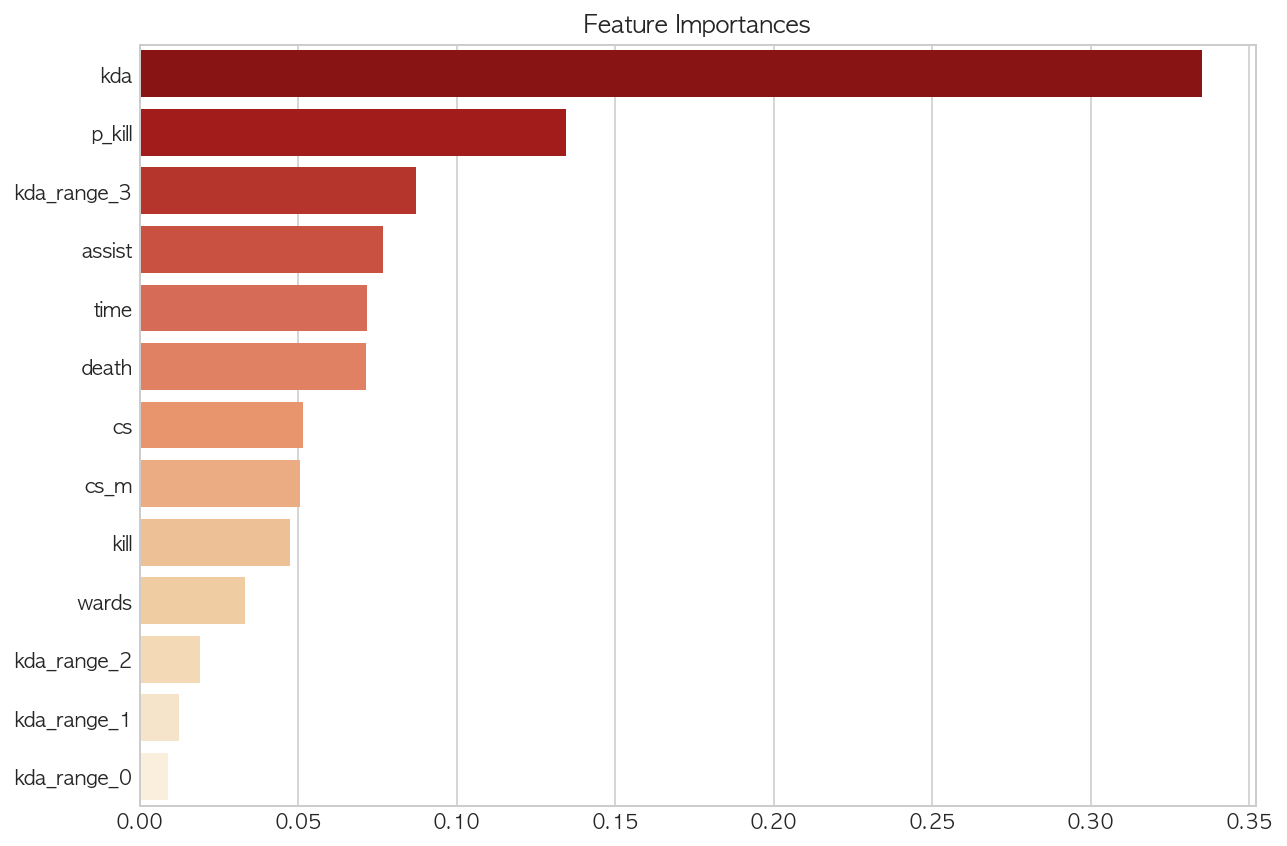

In [12]:
plt.figure(figsize=(10, 7))

sns.barplot(x=imps, y=cols, palette='OrRd_r')
plt.title('Feature Importances')
plt.show()

### Feature Importances

- KDA/킬 관여율/death/assist/KDA 3 이상일 것
- 1) Death 대비 Kill/Assist (3인분 이상)와 2) 얼마나 덜 죽고 3) 킬에 많이 관여하는 지

In [13]:
test, test_label = PrepareData(test).prepare_data()
test_pred = model.predict(test)

In [14]:
print(confusion_matrix(test_label, test_pred))

[[1745  246]
 [ 273 2029]]


In [15]:
print(classification_report(test_label, test_pred))

             precision    recall  f1-score   support

          0       0.86      0.88      0.87      1991
          1       0.89      0.88      0.89      2302

avg / total       0.88      0.88      0.88      4293



## 2. Logistic Regression

- Precision/Recall/F1: 0.90/0.90/0.90

In [16]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=random_state)
model_lr = lr.fit(X_train, y_train)

In [17]:
cv_scores = cross_val_score(model_lr, X_train, y_train, cv=cv)

print('Cross Val Scores: ', cv_scores)
print('Avg Score of CV: {:.3f}'.format(cv_scores.mean()))

Cross Val Scores:  [ 0.89492754  0.89389234  0.89182195  0.89440994  0.91351631]
Avg Score of CV: 0.898


In [18]:
test_pred = model_lr.predict(test)

In [19]:
print(confusion_matrix(test_label, test_pred))

[[1752  239]
 [ 210 2092]]


In [20]:
print(classification_report(test_label, test_pred))

             precision    recall  f1-score   support

          0       0.89      0.88      0.89      1991
          1       0.90      0.91      0.90      2302

avg / total       0.90      0.90      0.90      4293



## 3. XGBoost

- Precision/Recall/Fl: 0.90/0.90/0/90

In [21]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train.values, label=y_train)
dtest = xgb.DMatrix(X_test.values, label=y_test)

In [22]:
num_boost_round = 200
params = {'objective': 'multi:softmax', 
          'eval_metric': 'mlogloss',
          'num_class': 2, 
          'max_delta_step': 3, 
          'eta': 0.2}

evals = [(dtrain, 'train'), (dtest, 'eval')]

bst = xgb.train(params=params,  
                dtrain=dtrain, 
                num_boost_round=num_boost_round, 
                evals=evals,
                early_stopping_rounds=10)

[0]	train-mlogloss:0.573123	eval-mlogloss:0.576058
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:0.489844	eval-mlogloss:0.496965
[2]	train-mlogloss:0.430451	eval-mlogloss:0.440728
[3]	train-mlogloss:0.384064	eval-mlogloss:0.39803
[4]	train-mlogloss:0.34949	eval-mlogloss:0.3666
[5]	train-mlogloss:0.32157	eval-mlogloss:0.340702
[6]	train-mlogloss:0.298083	eval-mlogloss:0.320698
[7]	train-mlogloss:0.279595	eval-mlogloss:0.30472
[8]	train-mlogloss:0.264352	eval-mlogloss:0.292407
[9]	train-mlogloss:0.25173	eval-mlogloss:0.282364
[10]	train-mlogloss:0.240854	eval-mlogloss:0.274798
[11]	train-mlogloss:0.231276	eval-mlogloss:0.267253
[12]	train-mlogloss:0.222941	eval-mlogloss:0.260934
[13]	train-mlogloss:0.214971	eval-mlogloss:0.255597
[14]	train-mlogloss:0.20855	eval-mlogloss:0.251381
[15]	train-mlogloss:0.202772	eval-mlogloss:0.248604
[16]	train-mlogloss:0.197628	eval-m

In [23]:
pred_xgb = bst.predict(dtest)

In [24]:
print(confusion_matrix(y_test, pred_xgb))

[[1338  156]
 [ 136 1590]]


In [25]:
print(classification_report(y_test, pred_xgb))

             precision    recall  f1-score   support

          0       0.91      0.90      0.90      1494
          1       0.91      0.92      0.92      1726

avg / total       0.91      0.91      0.91      3220



In [26]:
dtest_data = xgb.DMatrix(test.values, label=test_label)
pred = bst.predict(dtest_data)

In [27]:
print(confusion_matrix(test_label, pred))

[[1754  237]
 [ 191 2111]]


In [28]:
print(classification_report(test_label, pred))

             precision    recall  f1-score   support

          0       0.90      0.88      0.89      1991
          1       0.90      0.92      0.91      2302

avg / total       0.90      0.90      0.90      4293

